<a href="https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/03_Interpretable_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# AIPI 590 - XAI | Assignment 03

#Description: Interpretable AI
This notebook is for exploring interpretable models for evaluating the churn predictions for a telecom company. The dataset is from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code.

## Chad Miller

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/03_Interpretable_AI.ipynb)

Acknowledgements: Class Repository, kaggle telco-customer-churn dataset

In [1]:
import os

# Remove Colab default sample_data
!rm -r /content/sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590-XAI"
git_path = 'https://github.com/mille055/AIPI590-XAI.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"


notebook_dir = 'Assignments'
path_to_notebook = os.path.join(repo_name,notebook_dir)


Cloning into 'AIPI590-XAI'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 88 (delta 47), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 469.67 KiB | 8.70 MiB/s, done.
Resolving deltas: 100% (47/47), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00


In [2]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import tabulate
import urllib.request
import zipfile
import pandas as pd

## Imports for data exploration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet




In [3]:
# Get secrets if necessary
# from google.colab import userdata
# userdata.get('secretName')

In [4]:
# Get device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print('device is ', device)

device is  cuda:0


In [16]:
# Define the paths where the zip files will be downloaded and extracted
DATA_PATH = 'AIPI590-XAI/Assignments/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Download the datafile and convert to pandas
churn_df = pd.read_csv(DATA_PATH)
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Describe:
        SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   Mult

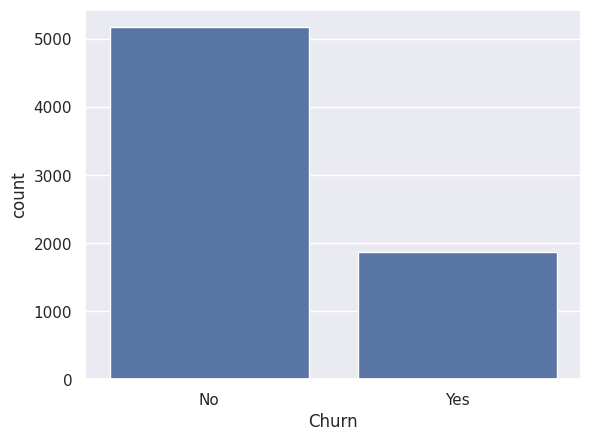

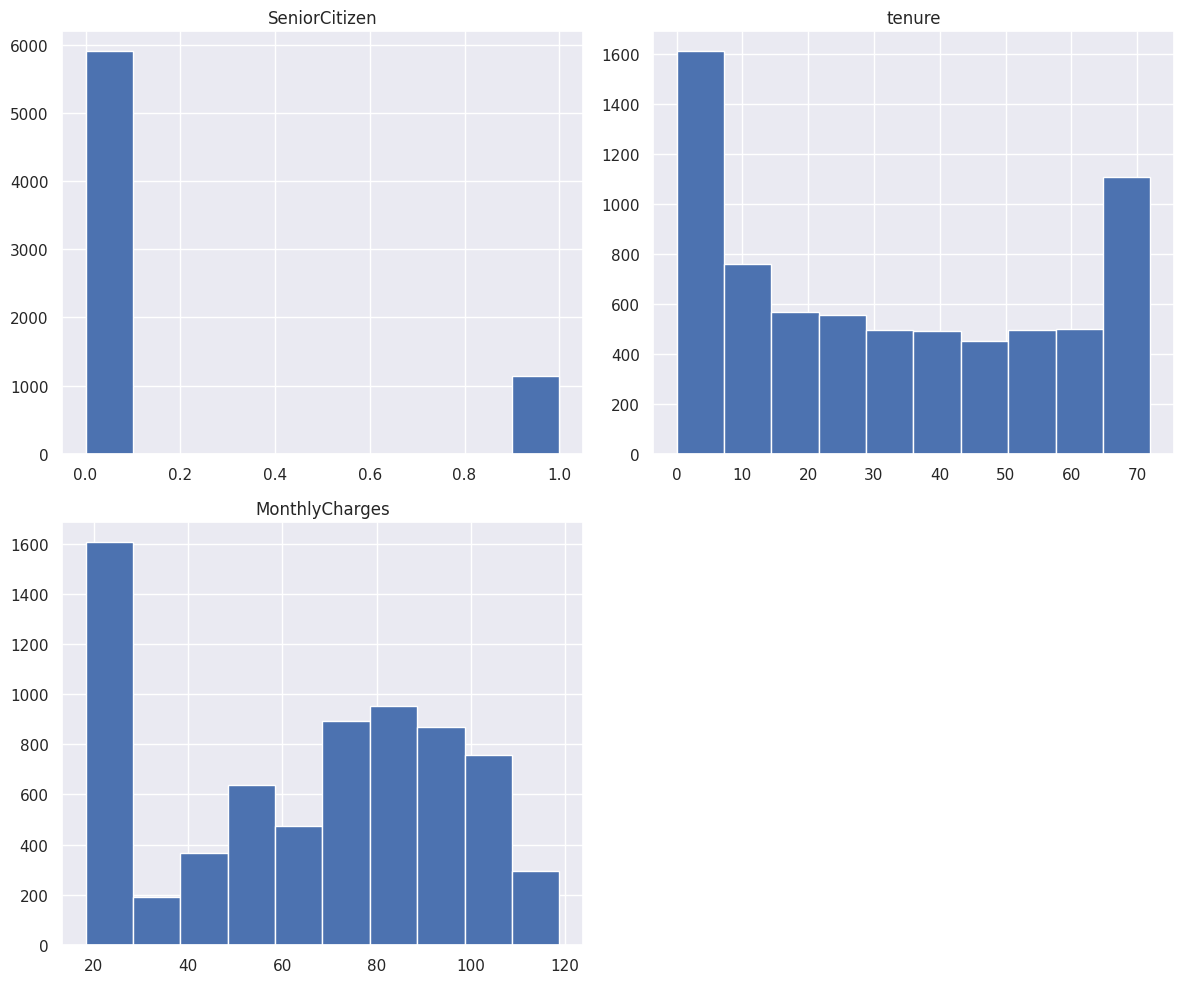

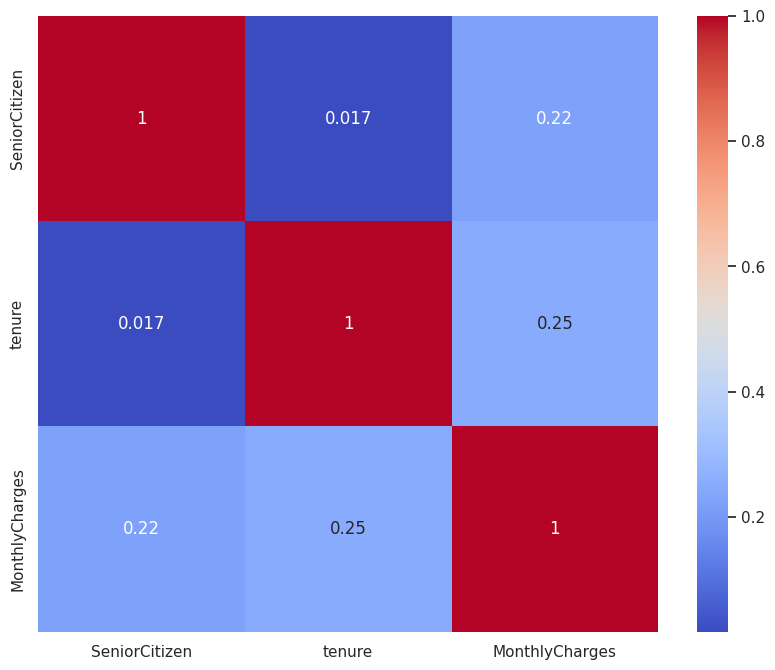

KeyError: 'Churn'

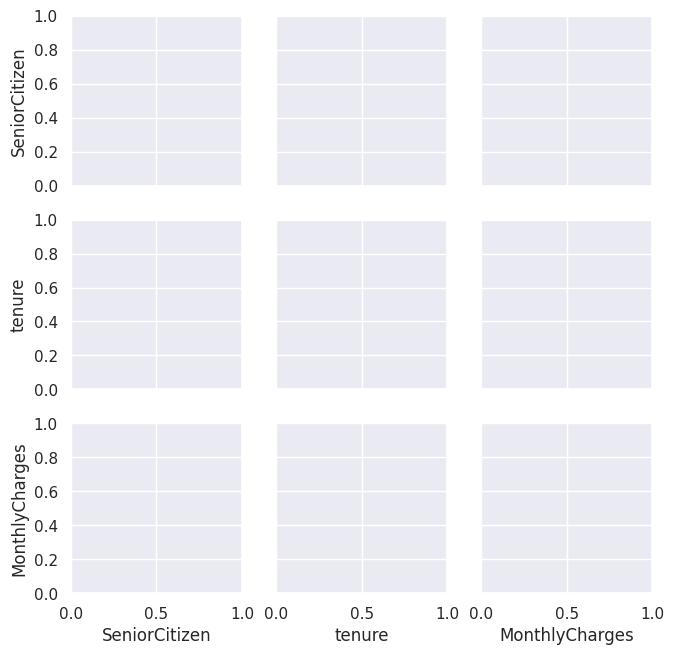

In [28]:

def EDA(df):
  df1= df.copy()
  print("Describe:\n", df1.describe())
  print("\nInfo:\n", df1.info())
  print("\nShape:\n", df1.shape)
  print("\nNull Values:\n", df1.isnull().sum())

  # Visualize distribution of churn
  sns.countplot(x='Churn', data=df1)
  plt.show()

  # Visualize numerical features
  df1.hist(figsize=(12,10))
  plt.tight_layout()
  plt.show()

  # Correlation matrix for numerical features after dropping any non-numeric columns

  df1_numeric = df1.select_dtypes(include=['float64', 'int64'])
  corr_matrix = df1_numeric.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
  plt.show()



EDA(churn_df)

In [ ]:
# Get the model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 187MB/s]


In [ ]:
# Some constant values

# ImageNet mean and std
NORM_MEAN = [0.4914, 0.4822, 0.4465]
NORM_STD = [0.2023, 0.1994, 0.2010]
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]

# Patch information
class_names = ['basketball']
patch_sizes = [32, 48, 64]

with open(os.path.join('/content/', path_to_notebook, 'imagenet_classes.txt'), 'r') as f:
  label_names = [line.strip() for line in f.readlines()]
  target_class = label_names.index('basketball')


In [ ]:
# places patch in random location without rotation
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [ ]:
# places patch in random location with rotation
def place_patch_rotation(img, patch):
    for i in range(img.shape[0]):
        # Rotate random amount between 0 and 360 degrees
        angle = np.random.uniform(0, 360)
        rotated_patch = TF.rotate(patch, angle)

        # Ensure the rotated patch still fits within the image
        h_offset = np.random.randint(0, img.shape[2] - rotated_patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - rotated_patch.shape[2] - 1)

        # Apply the patch to the image at the random location
        img[i, :, h_offset:h_offset+rotated_patch.shape[1], w_offset:w_offset+rotated_patch.shape[2]] = patch_forward(rotated_patch)

    return img

In [ ]:

def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [ ]:
# Evaluate the patch, displaying accuracy and top5
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch_rotation(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    print('accuracy:', acc.item(), 'top5:', top5.item())
    return acc, top5

In [ ]:
# Train/optimize the patch using the tiny imagenet dataset
def patch_attack(model, target_class, dataset=tiny_imagenet_dataset, patch_size=64, num_epochs=5):

    #dataset = ImageNet(root='AIPI590-XAI/Assingments/data', train=True, download=True, transform=transforms.ToTensor())
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch_rotation(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [ ]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [ ]:
# Generate/train the patches for the desired classes and sizes, stored in a dictionary
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [ ]:
patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

accuracy: 0.41783568263053894 top5: 0.6487975716590881
Validation results for basketball and 32: {'acc': 0.41783568263053894, 'top5': 0.6487975716590881}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

accuracy: 0.43128126859664917 top5: 0.6630630493164062


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

accuracy: 0.8111222386360168 top5: 0.9278557300567627
Validation results for basketball and 48: {'acc': 0.8111222386360168, 'top5': 0.9278557300567627}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

accuracy: 0.7978478670120239 top5: 0.9259259104728699


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

accuracy: 0.8992986083030701 top5: 0.9849699139595032
Validation results for basketball and 64: {'acc': 0.8992986083030701, 'top5': 0.9849699139595032}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

accuracy: 0.9136136174201965 top5: 0.9862862825393677


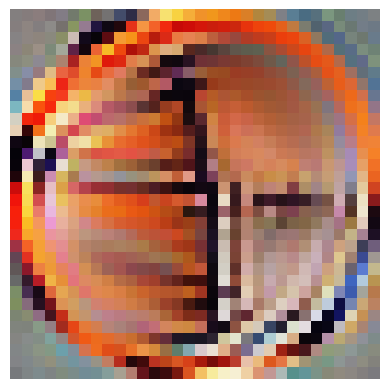

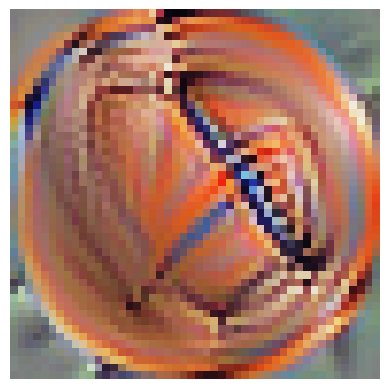

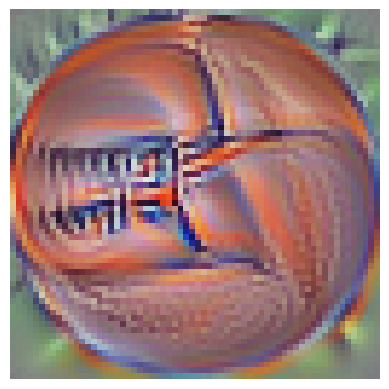

Patches saved in 'patch_images' directory.


In [ ]:
def save_and_display_patches(output_dir="patch_images"):
    # Create directory to save the patches if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2  # Convert to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)

            # Create figure and plot the patch
            plt.figure(figsize=(2.2, 2.2))  # Set the figure size for each patch
            plt.imshow(patch)
            plt.axis('off')  # Turn off the axis

            # Save the patch as a .png file
            file_name = f"{cname}_size_{psize}.png"
            file_path = os.path.join(output_dir, file_name)
            plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
            plt.close()  # Close the figure after saving to avoid memory issues

            # Display the image (optional)
            plt.imshow(patch)
            plt.axis('off')  # Turn off the axis for display
            plt.show()

    print(f"Patches saved in '{output_dir}' directory.")

save_and_display_patches()
